Install Packages

In [5]:
!pip install rapidfuzz
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

Import Libraries

In [6]:
import os
import torch
import torchvision.transforms.functional as F
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageOps
import xml.etree.ElementTree as ET
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from sentence_transformers import SentenceTransformer, util
from rapidfuzz import process, fuzz
import torch.nn as nn
import requests


Define Classes: LabelEncoder + CRNN

In [7]:
import torch.nn as nn

class LabelEncoder:
    def __init__(self):
        self.characters = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-.,:/()"
        self.char2idx = {char: idx + 1 for idx, char in enumerate(self.characters)}
        self.idx2char = {idx + 1: char for idx, char in enumerate(self.characters)}
        self.blank_label = 0

    def encode(self, text):
        return [self.char2idx[char] for char in text if char in self.char2idx]

    def decode(self, indices):
        return ''.join([self.idx2char.get(idx, '') for idx in indices if idx != self.blank_label])

    def get_vocab_size(self):
        return len(self.char2idx) + 1

class CRNN(nn.Module):
    def __init__(self, img_height, num_classes):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(), nn.MaxPool2d((2, 1)),
            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d((2, 1)),
            nn.Conv2d(512, 512, 2, 1, 0), nn.ReLU()
        )
        self.rnn1 = nn.LSTM(512, 256, batch_first=True, bidirectional=True)
        self.rnn2 = nn.LSTM(512, 256, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        b, c, h, w = x.size()
        assert h == 1
        x = x.squeeze(2)
        x = x.permute(0, 2, 1)
        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        return self.fc(x)


Path Setup

In [8]:
# Paths
images_folder = "/content/drive/MyDrive/Individual_Research_Project/images/"
xml_folder = "/content/drive/MyDrive/Individual_Research_Project/raw_xml/"
model_crnn_path = "/content/drive/MyDrive/Individual_Research_Project/models/crnn_prescription_final.pth"
model_fasterrcnn_path = "/content/drive/MyDrive/Individual_Research_Project/models/faster_rcnn_words_new_1.pth"
kb_main_path = "/content/drive/MyDrive/Individual_Research_Project/knowledge_base.xlsx"
kb_side_path = "/content/drive/MyDrive/Individual_Research_Project/SideEffects.csv"
kb_shortform_path = "/content/drive/MyDrive/Individual_Research_Project/short_form_mapping.csv"


Load Models (Faster R-CNN + CRNN + Knowledge Base)

In [9]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Faster R-CNN
model_detector = fasterrcnn_resnet50_fpn(weights=None, num_classes=2)
model_detector.load_state_dict(torch.load(model_fasterrcnn_path, map_location=device))
model_detector = model_detector.to(device).eval()

# Load CRNN Model
encoder = LabelEncoder()
model_crnn = CRNN(img_height=32, num_classes=encoder.get_vocab_size())
model_crnn.load_state_dict(torch.load(model_crnn_path, map_location=device))
model_crnn = model_crnn.to(device).eval()

# Load Knowledge Base 1 (Main KB: Drug + Category)
kb_main_df = pd.read_excel(kb_main_path).dropna(subset=["Entry", "Category"])
kb_main_entries = kb_main_df["Entry"].astype(str).str.lower().tolist()
kb_main_categories = kb_main_df["Category"].str.lower().tolist()

# Load Knowledge Base 2 (Side Effects & Usage)
kb_side_df = pd.read_csv(kb_side_path, encoding="ISO-8859-1")
kb_side_df.columns = kb_side_df.columns.str.strip().str.lower().str.replace(" ", "_")

# Load Knowledge Base 3 (Short Forms)
short_form_df = pd.read_csv(kb_shortform_path)
short_form_df.columns = short_form_df.columns.str.strip().str.lower().str.replace(" ", "_")
short_to_full = dict(zip(short_form_df["abbreviation"], short_form_df["full_drug_name"]))

# Load Sentence Transformer
model_st = SentenceTransformer("all-MiniLM-L6-v2")
kb_main_embeddings = model_st.encode(kb_main_entries, convert_to_tensor=True)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 110MB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

utilities

In [10]:
# Step 1: Resize and Pad for CRNN Input
def resize_and_pad(img, size=(128, 32)):
    img = img.convert("L")
    w, h = img.size
    scale = size[1] / h
    new_w = int(w * scale)
    img = img.resize((new_w, size[1]), Image.BILINEAR)
    if new_w > size[0]:
        img = img.resize(size, Image.BILINEAR)
    else:
        pad = (size[0] - new_w) // 2
        img = ImageOps.expand(img, (pad, 0, size[0] - new_w - pad, 0), fill=255)
    return img

# Step 2: OCR with CRNN
def predict_word(crop):
    crop = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
    crop = resize_and_pad(Image.fromarray(crop))
    image = F.to_tensor(crop).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model_crnn(image)
        output = output.softmax(2)
        pred_idx = torch.argmax(output, dim=2).squeeze().tolist()
        return encoder.decode(pred_idx).strip()

# Step 3: Short form → full drug name
def expand_short_form(word):
    return short_to_full.get(word.lower(), word)

# Step 4: Spell correction using fuzzy matching
def correct_spell(word, kb_entries, threshold=80):
    best, score, _ = process.extractOne(word, kb_entries, scorer=fuzz.ratio)
    return best if score >= threshold else word

# Step 5: KB Matching using embeddings
def match_to_kb(pred_text, kb_entries, kb_embeddings, threshold=0.6):
    emb = model_st.encode(pred_text, convert_to_tensor=True)
    sim = util.cos_sim(emb, kb_embeddings)[0]
    best_idx = int(sim.argmax())
    if float(sim[best_idx]) >= threshold:
        return kb_entries[best_idx], kb_main_categories[best_idx], float(sim[best_idx])
    else:
        return "No Match", "N/A", float(sim[best_idx])

# Step 6: Get usage + side effects
def get_side_info(drug_name):
    drug_name = drug_name.lower().strip()
    match = kb_side_df[kb_side_df["drug_name"].str.lower().str.strip() == drug_name]
    if not match.empty:
        return match["common_usage"].values[0], match["side_effects"].values[0]
    else:
        return "Not Available", "Not Available"


Full Detection + OCR + KB Matching Pipeline

In [ ]:
results = []

for fname in os.listdir(images_folder):
    if fname.endswith((".jpg", ".png")):
        path = os.path.join(images_folder, fname)
        img = Image.open(path).convert("RGB")
        img_tensor = F.to_tensor(img).unsqueeze(0).to(device)

        with torch.no_grad():
            preds = model_detector(img_tensor)

        boxes = preds[0]["boxes"].cpu().numpy()
        scores = preds[0]["scores"].cpu().numpy()
        selected = boxes[scores > 0.4]

        img_cv = np.array(img)

        for box in selected:
            x1, y1, x2, y2 = box.astype(int)
            crop = img_cv[y1:y2, x1:x2]

            # OCR
            pred_raw = predict_word(crop)

            # Step 1: Expand short form first
            expanded = expand_short_form(pred_raw)

            # Step 2: Spell correct
            corrected = correct_spell(expanded.lower(), kb_main_entries)

            # Step 3: KB match
            matched_entry, category, sim = match_to_kb(corrected, kb_main_entries, kb_main_embeddings)

            # Step 4: Lookup usage + side effects
            common_usage, side_effects = get_side_info(corrected)

            results.append({
                "Image": fname,
                "Predicted Text": pred_raw,
                "After Short Form": expanded,
                "Corrected": corrected,
                "Matched Entry": matched_entry,
                "Category": category,
                "Similarity": sim,
                "Common Usage": common_usage,
                "Long Term Side Effects": side_effects
            })

# Save
df_final = pd.DataFrame(results)
output_path = "/content/drive/MyDrive/Individual_Research_Project/final_predictions_all_new.csv"
df_final.to_csv(output_path, index=False)
print("Saved to:", output_path)


Saved to: /content/drive/MyDrive/Individual_Research_Project/final_predictions_all_new.csv


Evaluation Metrics

In [11]:
# Prepare ground truth and prediction lists
y_true = []
y_pred = []

def extract_ground_truth(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    gt_words = []
    for obj in root.findall('object'):
        label = obj.find('name').text.strip()
        gt_words.append(label.lower())
    return gt_words

def match(pred, gt_list, threshold=80):
    match, score, _ = process.extractOne(pred, gt_list, scorer=fuzz.ratio)
    return score >= threshold

print("Running full evaluation...")

for img_name in os.listdir(images_folder):
    if img_name.endswith(".jpg") or img_name.endswith(".png"):
        img_path = os.path.join(images_folder, img_name)
        img = Image.open(img_path).convert("RGB")
        img_tensor = F.to_tensor(img).unsqueeze(0).to(device)

        with torch.no_grad():
            prediction = model_detector(img_tensor)

        boxes = prediction[0]['boxes'].detach().cpu().numpy()
        scores = prediction[0]['scores'].detach().cpu().numpy()

        threshold = 0.6
        selected_boxes = boxes[scores > threshold]
        img_cv = np.array(img)

        preds = []
        for box in selected_boxes:
            x1, y1, x2, y2 = box.astype(int)
            crop = img_cv[y1:y2, x1:x2]
            pred_text = predict_word(crop)
            preds.append(pred_text.lower())

        # Load ground truth
        xml_name = img_name.replace(".jpg", ".xml").replace(".png", ".xml")
        xml_path = os.path.join(xml_folder, xml_name)
        if not os.path.exists(xml_path):
            continue
        gt_words = extract_ground_truth(xml_path)

        for pred in preds:
            if len(gt_words) > 0:
                best_match = match(pred, gt_words)
                y_pred.append(1 if best_match else 0)
                y_true.append(1)

# Calculate Metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

print("\n FINAL METRICS:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Overall Word Accuracy: {accuracy:.4f}")


Running full evaluation...

 FINAL METRICS:
Precision: 1.0000
Recall: 0.2239
F1 Score: 0.3658
Overall Word Accuracy: 0.2239


Plotting Performance Graph

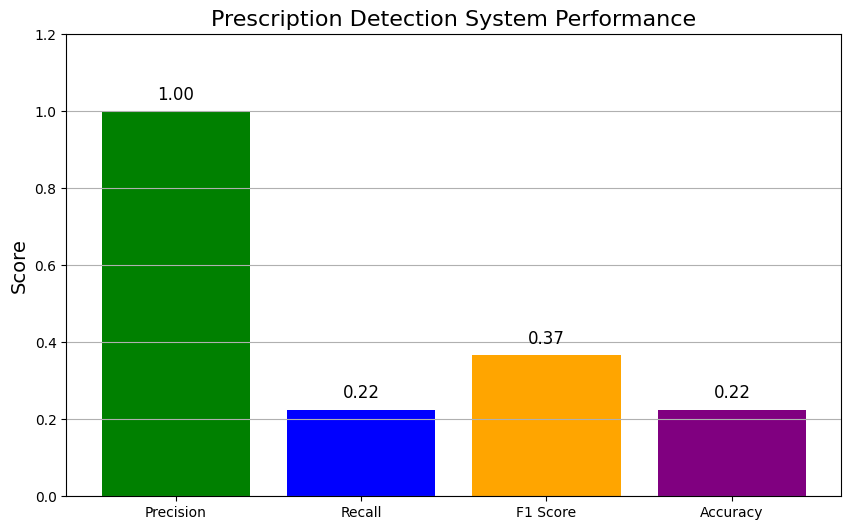

In [ ]:
# Plot Metrics
metrics = ['Precision', 'Recall', 'F1 Score', 'Accuracy']
values = [precision, recall, f1, accuracy]

plt.figure(figsize=(10,6))
bars = plt.bar(metrics, values, color=['green', 'blue', 'orange', 'purple'])
plt.ylim(0, 1.2)
plt.title('Prescription Detection System Performance', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.grid(axis='y')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

plt.show()


In [2]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



Classification Report:
              precision    recall  f1-score   support

   Incorrect       0.00      0.00      0.00         0
     Correct       1.00      0.22      0.37      6933

    accuracy                           0.22      6933
   macro avg       0.50      0.11      0.18      6933
weighted avg       1.00      0.22      0.37      6933



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


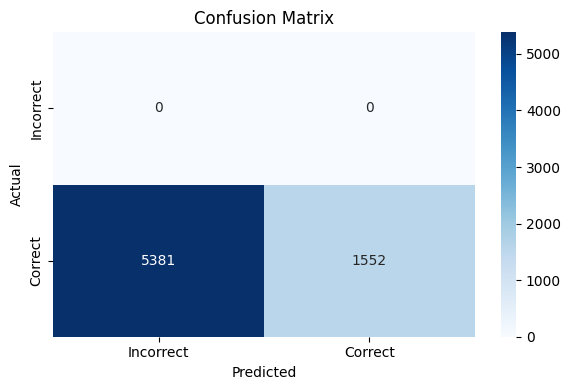

In [12]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Incorrect", "Correct"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Incorrect", "Correct"], yticklabels=["Incorrect", "Correct"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
